In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn.cluster import KMeans
from scipy.special import factorial
from scipy.stats import poisson

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

The idea is to buid a HMM model that infers state changes during chemotaxis. I expect to capture state transitions during chemotaxis and non-stationarity over optogenetic stimulations.

An extention to GLM-HMM and input-driven AR-HMM would be ideal to capture sensory-guided behavior that is both switching and continously driven by input.

The following test codes follows the PRML book and Sarah's matalb code...

(3, 1000)

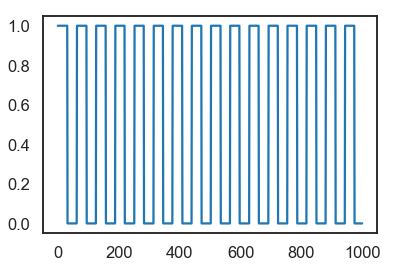

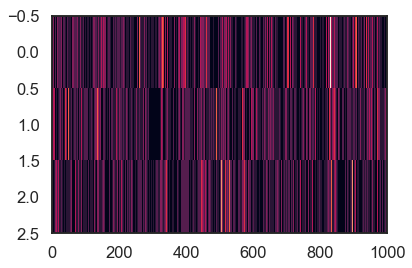

In [120]:
##simple simulation state-modulated Poisson process
#parameters
# X = np.random.randi(4,1000)  #data (4X1000 for example eigen worm time series)
#X = np.random.randint(5, size=(4,1000))
N = 3   #observations  (eigen worms)
T = 1000  #time series
nstates = 2  #number of states

xx = np.arange(0,T)
zz = np.sin(xx/10)
zz[zz>=0] = 1
#pos = np.intersect1d(np.where(zz<1)[0],np.where(zz>-0.5)[0])
#zz[pos]=2
zz[zz<=0] = 0
plt.plot(zz)

X = []
for ii in range(0,N):
    pp = np.zeros(T)
    pos = np.where(zz==0)[0]
    pp[pos] = np.random.poisson(1,size=(len(pos)))
    pos = np.where(zz==1)[0]
    pp[pos] = np.random.poisson(2,size=(len(pos)))
    X.append(pp)#*zz)

plt.figure()
plt.imshow(X,aspect='auto')
X = np.array(X)
X.shape

In [2]:
def RaisedCosine_basis(nkbins,nBases):
    """
    Raised cosine basis function to tile the time course of the response kernel
    nkbins of time points in the kernel and nBases for the number of basis functions
    """
    #nBases = 3
    #nkbins = 10 #binfun(duration); # number of bins for the basis functions
    ttb = np.tile(np.log(np.arange(0,nkbins)+1)/np.log(1.5),(nBases,1))  #take log for nonlinear time
    #ttb = np.tile(np.arange(0,nkbins),(nBases,1))
    dbcenter = nkbins / (nBases+3) # spacing between bumps
    width = 4*dbcenter # width of each bump
    bcenters = 2.*dbcenter + dbcenter*np.arange(0,nBases)  # location of each bump centers
    def bfun(x,period):
        return (abs(x/period)<0.5)*(np.cos(x*2*np.pi/period)*.5+.5)
    temp = ttb - np.tile(bcenters,(nkbins,1)).T
    BBstm = [bfun(xx,width) for xx in temp] 
    #plt.plot(np.array(BBstm).T)
    return np.array(BBstm)

In [56]:
def A_ij(Fij,s,nbases):
    """
    GLM transition matrix
    Fij as filters on stimulus s for transition from i to j, s as stimuli, and r for regularization
    Fij has size k x k x b, where k is hidden states and b is number of basis
    """
    Aij = np.zeros((Fij.shape[0],Fij.shape[1]))  #transition matrix
    nkb = Fij.shape[2]  #weights on the basis
    for ki in range(0,Aij.shape[0]):
        for kj in range(0,Aij.shape[1]):
            Aij[ki,kj] = np.exp( np.dot( np.dot( RaisedCosine_basis(nkb,nbases), Fij[ki,kj,:] ) ,s ) )
    Aij = Aij/np.sum(Aij,axis=1)
    return Aij

In [57]:
def P_y_th(Fn,s,nbases):
    """
    GLM emission probability
    Fn as filters on stimulus s at mode n
    Fn has size n x b, where n is the dimension of the multi-nomial (ex: angle and speed) 
    and b is the number of basis
    """
    P_y = np.zeros(Fn.shape[0])
    nkb = Fn.shape[1]
    for kn in range(0,P_y.shape[0]):
        P_y[kn] = np.exp( np.dot( np.dot( RaisedCosine_basis(nkb,nbases), Fn[kn,:] ) ,s ) )
    P_y = P_y/np.sum(P_y)
    return P_y

In [55]:
test = A_ij(np.random.rand(3,3,5),np.random.rand(10),10)
print(test.sum(1))
test = P_y_th(np.random.rand(3,5),np.random.rand(10),10)
test

[1.16461536 1.05532428 0.82199104]


array([1.34304305, 2.1560964 , 2.29724854])

In [192]:
###Test with GLM-HMM, where GLM affects both transitions and emissions

#fake data
X; # X is nmulti X T, with nmulti observable in time series T
T = 1000 #X.shape[1]
#filter and stimulus parameters
nbases = 5   #using number of basis for the filter  (with raised-cosine)
window = 10  #window size acting on the stimulus  (kernel/memory length)
nmulti = 2   #number of output multinomials (assume angle and velocity)
nstates = 3  #number of hidden states (assume steering, turning, and pause/ambiguous)
#stimulus into design matrix
stimuli = np.random.rand(T)
stim = np.zeros((T-window),window)
for st in range(0,T-window):
    stim[st,:] = stimuli[st:st+window]

#initialize filter paramter
Fij = np.random.rand(nstates,nstates,nbases)  #for state transitions
Fn = np.random.rand(nmulti,nbases)  #for emissions

#initialize states
pi = np.ones(nstates)/nstates  #initial distribution
# A = np.ones((nstates,nstates))/nstates**2  #initial transition matrix
# temp = np.random.rand(nstates,nstates)
# A = temp/np.sum(temp)
A = A_ij(Fij,stim[0,:],nbases)

#initielize emission
lams = np.zeros(nmulti)
for nn in range(0,nmulti):
    lams[nn] = P_y_th(Fn,stim[0,:],nbases)
    
#initialize emitted clusters
kmeans = KMeans(n_clusters=nstates, random_state=0).fit(X.T)   #initialize with k-means
temp = kmeans.labels_
labels = np.zeros((T,nstates))
for tt in range(0,T):
    labels[tt,temp[tt]] = 1   #identifying transition in the time series

#input fake data initialization
maxiter = 50  #iterations of update
tol = 0.000  #tolerance of error

#log-likelihood
LL_train = np.empty(maxiter)
dLL = 1
ii = 0

#Update iteration
while ii<maxiter-1:
    ##### forward recursion #####
    #initialization
    alphas = np.zeros((T,nstates))  #forward pass alphas
    px_z = np.zeros((T,nstates))    #data likelihood (probability of x given k)
    c = np.zeros(T)                 #variable to store marginal
    
    #px_z[0,:] = np.exp( np.nansum(-lams + np.matmul(X[:,0],np.log(lams)) - np.log(math.factorial(X[:,0]))) )  
    #px_z[0,:] = 1*np.exp( np.nansum(-lams + np.repeat(X[:,0][:,None],nstates,axis=1)*np.log(lams) 
    #                                - np.repeat(np.log(factorial(X[:,0]))[:,None],nstates,axis=1),axis=0) ) 
    #alphas[0,:] = pi*px_z[0,:]          #initial alpha, equation 13.37 
    px_z[0,:] = P_y_th(Fn,stim[0,:],nbases)  #temp
    alphas[0,:] = A_ij(Fij,stim[0,:],nbases)
    c[0] = np.sum(alphas[0,:]);         #store marginal likelihood
    alphas[0,:] = alphas[0,:]/c[0]      #normalize 13.59
    
    #iterate of alpha
    for tt in range(1,T):
        #p(x|z)(n,:) = prod(exp(-lambdas).*lambdas.^spikes(:,n)./fac_spikes(:,n))
        ###px_k(1,:) = exp(nansum(-lambdas + spikes(:,1).*log(lambdas) - log(fac_spikes(:,1))));
        #temp = np.exp( np.nansum(-lams + np.repeat(X[:,tt][:,None],nstates,axis=1)*np.log(lams) 
        #                      - np.repeat(np.log(factorial(X[:,tt]))[:,None],nstates,axis=1),axis=0) ) 
        px_z[tt,:] = P_y_th(Fn,stim[tt,:],nbases)  #temp
        alphas[tt,:] = A_ij(Fij,stim[tt,:],nbases)  #px_z[tt,:]*np.sum(alphas[tt-1,:]*A,axis=1)   # equation 13.36  
    
        c[tt] = np.sum(alphas[tt,:]);                        # marginal likelihood
        alphas[tt,:] = alphas[tt,:]/np.sum(alphas[tt,:])     # normalize 13.59
        
    LL_train[ii] = np.sum(np.log(c));                          #store log-likelihood
    if ii>0:
        dLL = LL_train[ii] - LL_train[ii-1]      #compute difference if >1 iterations have occurred
        
    ##### backward recursion #####
    #initialization
    betas = np.zeros((T,nstates))    #backward passing beta
    betas[-1,:] = np.ones(nstates)/nstates   #inital beta (13.39)
    
    #iterate of beta
    backt = np.arange(T-2,-1,-1)
    for tt in backt:
        betas[tt,:] = np.sum(betas[tt+1,:]*px_z[tt+1,:]*A,axis=1) #equation  13.38 
        betas[tt,:] = betas[tt,:]/c[tt+1]                         #normalize 13.62
        
    ##### Update parameters #####
    #gamma - eq. 13.33
    temp = alphas*betas
    gammas = temp/np.repeat(np.sum(temp,axis=1)[:,None],nstates,axis=1)
    
    #xi - eq. 13.43
    xis = np.zeros((T-1,nstates,nstates))
    for tt in range(1,T):
        xis[tt-1,:,:] = alphas[tt-1,:]*px_z[tt,:]*A*betas[tt,:]
        xis[tt-1,:] = xis[tt-1,:]/np.sum(xis[tt-1,:])
    
    #initial state prob - eq. 13.18
    pi = gammas[0,:]/np.sum(gammas[0,:])
    
    #transition matrix  - eq. 12.19
    A = np.sum(xis,axis=0)#np.squeeze(np.sum(xis,axis=0))
    A = A/np.sum(A,axis=1)
    
    #emission probability - eq. 13.23
    for nn in range(0,N):
        lams[nn,:] = np.matmul(X[nn,:],gammas)/np.sum(gammas,axis=0)

    ii = ii + 1

49
-5.194924597162753e-07


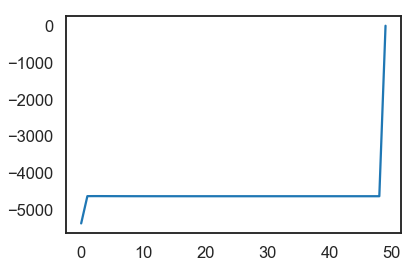

In [193]:
plt.plot(LL_train)
print(ii)
print(dLL)

Modified the Viterbi algorithm from this repository: https://github.com/nhchristianson/PoissonHMM

In [223]:
seq = X[0,:]
theta = np.log(A)
delta = np.log(pi)
lambdas = lams[0,:]

In [230]:
def _sp_lpmf(mean, val):
    if mean == -1:
        if val == -1:
            return 0
        else:
            return -np.inf
    elif mean >= 0:
        if val == -1:
            return -np.inf
        else:
            return poisson(mean).logpmf(val)

In [225]:
v_n = [0.0 for _ in range(nstates)]
vlst = [v_n]
wlst = []
for i in range(len(seq) - 1, 0, -1):
    v_i = []
    w_i = []
    for j in range(nstates):
        all_v_ij = []
        for k in range(nstates):
            temp = theta[j, k] + _sp_lpmf(lambdas[k], seq[i])
            temp += vlst[-1][k]
            all_v_ij.append(temp)
        v_i.append(max(all_v_ij))
        w_i.append(np.argmax(all_v_ij))
    vlst.append(v_i)
    wlst.append(w_i)
wlst.reverse()
first_prob = [_sp_lpmf(lambdas[i], seq[0]) for i in range(nstates)]
first_prob = np.add(first_prob, delta)
first_prob = np.add(first_prob, vlst[-1])
h_1 = np.argmax(first_prob)
statelst = [h_1]
for i in range(len(wlst)):
    statelst.append(wlst[i][statelst[-1]])


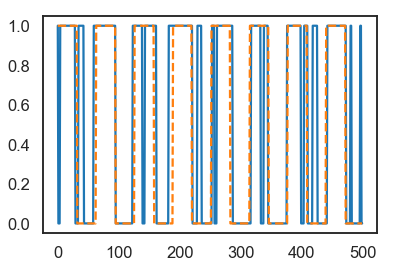

In [241]:
plt.plot(statelst[:500])
plt.plot(zz[:500],'--')